In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from changepoint_online import NPFocus
from mmdew.mmdew import MMDEW
from mmdew.fast_rbf_kernel import est_gamma
import pandas as pd

In [2]:
rng = np.random.default_rng()

In [3]:
d=20

In [4]:
change_at = 500

In [5]:
class MultiFocus():
    def __init__(self,d,sample):
        self.d = d
        self.statistics = []
        self.detectors = []
        for i in range(d):
            self.detectors += [NPFocus([np.quantile(sample[:100,i], q) for q in [0.25, 0.5, 0.75]])]

    def insert(self,elem):
        acc_stat = []
        for i in range(self.d):
            self.detectors[i].update(elem[i])
            acc_stat +=  [np.sum(self.detectors[i].statistic())]
        self.statistics += [np.mean(acc_stat)]

# Cov change

In [7]:
statistics = []
for _ in tqdm(range(20)):
    post_change = rng.multivariate_normal(mean=[0]*d, cov=np.ones((d,d)),size=change_at)
    #pre_change -= np.mean(pre_change, axis=0)
    #pre_change /= np.std(pre_change)  
    pre_change = rng.multivariate_normal(mean=[0]*d, cov=np.eye(d),size=100)

    data = np.concatenate((pre_change,post_change))    
    
    detector = MultiFocus(d=d,sample=pre_change)
    for elem in data:
        detector.insert(elem)
    statistics += [detector.statistics[0:]] # the first few have large variance

100%|███████████████████████████████████████████| 20/20 [01:04<00:00,  3.22s/it]


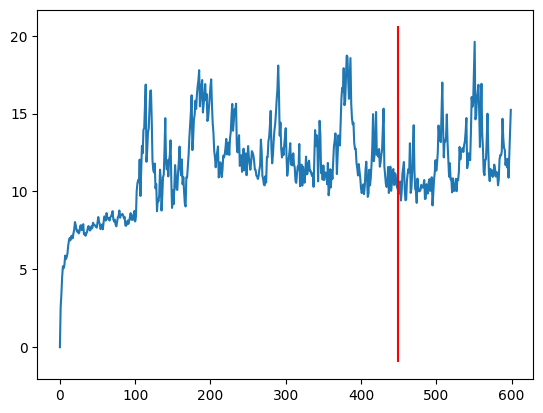

In [8]:
stats = np.max(np.array(statistics),axis=0)

plt.plot(stats)
ymin, ymax = plt.ylim()
plt.vlines(x=change_at-50-1,ymin=ymin,ymax=ymax,colors=["red"]) # -1 due to being zero-based

In [9]:
cov = pd.DataFrame(stats, columns=["test_stat"])
cov["algorithm"] = "Focus"
cov["experiment"] = "Covariance shift"

# Mean change

In [10]:
statistics = []
for _ in tqdm(range(20)):
    pre_change = rng.multivariate_normal(mean=[0]*d, cov=np.eye(d),size=change_at)
    post_change = rng.multivariate_normal(mean=[1]*d, cov=np.eye(d),size=100)    
    
    data = np.concatenate((pre_change,post_change))    
    
    detector = MultiFocus(d=d,sample=pre_change)
    for elem in data:
        detector.insert(elem)
    statistics += [detector.statistics[0:]] # the first few have large variance

100%|███████████████████████████████████████████| 20/20 [01:03<00:00,  3.19s/it]


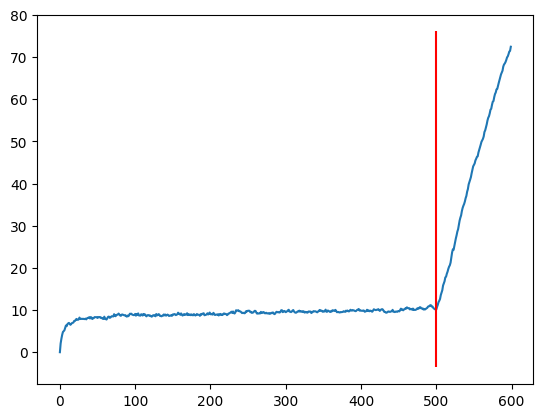

In [11]:
stats = np.max(np.array(statistics),axis=0)

plt.plot(stats)
ymin, ymax = plt.ylim()
plt.vlines(x=change_at-0-1,ymin=ymin,ymax=ymax,colors=["red"]) # -1 due to being zero-based

In [12]:
mean = pd.DataFrame(stats, columns=["test_stat"])
mean["algorithm"] = "Focus"
mean["experiment"] = "Mean shift"

In [13]:
df = pd.concat((cov,mean))

In [14]:
df.to_csv("results/focus-univariate.csv")